<a href="https://colab.research.google.com/github/HalimaLadan/NLP-Projects/blob/main/Text_Generation_using_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Generation using LSTMs**

## **Table of Contents**
------------------

- [Introduction](#intro)
- [Import libraries and packages](#ilp)
- [Dataset Information](#di)
- [Separate 'Title' field and preprocess it](#preprocess)
    - [Removing unwanted charaters and words](#remv)
    - [Tokenization and word_index (vocabulary) ](#token)
    - [Convert titles into sequences and make n_gram model](#ngram)
    - [Making all titles with same length and padding them](#pad)
- [Prepare features (X) and labels (Y)](#xy)
- [Architechture of the LSTM neural network](#lstm)
- [Train the LSTM neural network](#train)
- [Plotting the accuracy and loss graph](#acc)
- [Predict new title (Testing)](#new)

----------------




<a name="intro"></a>

# **Introduction**

Text Generation is the task of predicting what word comes next, given what words lies ahead of it. It can be thought of as a chain of Auto-Predict task, where the next word is continuously produced, from the current word. While dealing with text, the model needs to be trained to forget old Context, and update new Context, with each new words in the sequence, as each new words received brings some value-addition to the Context. For example, Pronouns are changed when the person talked about changes in the sentence.

Therefore,LSTM Reccurent Neural Networks will be leveraged to perform Text Generation. LSTM has a Context vector, and it has Forget gate to decide which part of the Old Context it should forget, an Input Gate to decide which part of the Input brings what change in the context,and an Output Gate to produce the Output or the next Word in this Text Generation task.


<a name="ilp"></a>
# **Importing the necessary libraries**

In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

<a name="di"></a>
# **Dataset Information**

**Import Medium-articles-dataset:**

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 Digital Sources. The assumption here is, by exposing the model to Natural Language in a particular domain, it will see instances of which words usually occur in sequence and therefore on training, it will learn the mapping of which words are likely to occur given a particular context. :

- Towards Data Science
- UX Collective
- The Startup
- The Writing Cooperative
- Data Driven Investor
- Better Humans
- Better Marketing

Dataset link: https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset


In [2]:
data = pd.read_csv('/content/medium_data.csv')
data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [3]:
print("Number of records: ", data.shape[0])
print("Number of fields: ", data.shape[1])

Number of records:  6508
Number of fields:  10


Here,  There're **10 different fields and 6508 records** but only the **title field** will be used to predict the next word.

<a name="preprocess"></a>
# **Displaying the titles of various articles and preprocessing them**

In [4]:
data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [5]:
data['title'][1]

'Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric'

<a name="remv"></a>
#### **Removing unwanted characters and words in titles**

Looking at the titles, It can be seen that there are some unwanted characters and words, which may not be useful for prediction purposes - in fact these characters and words may decrease the model's accuracy. Hence they have to be removed.

In [6]:
data['title'] = data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
data['title'] = data['title'].apply(lambda x: x.replace('\u200a',' '))

<a name="token"></a>
#### **Tokenization**

Tokenization is the process by which text is converted into separable units, i.e, words. But here, A pre-built Tokenizer will be used to convert each word to it's One-hot encoding indexe, by providing a unique ID to all the words.

In [7]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


<a name="ngram"></a>

### **Text into sequences and Generating n-gram Sequence for training**

NLP language models require sequential input data, and the input word/token must be numerical. Here we are generating n-grams in order to train our model for next word prediction.

Let's suppose we have a sentence such as **"I am good"** - this will convert into a sequence with their respective tokens **{'I' : 1, 'am' :  2, 'good' : 3}**.

Thus, the output would be:  **[ '1', '2', '3' ]**

Likewise, all our titles will be converted into sequences.

Then, we will make an n_gram model for good predictions.

The image below explains this process.
<img src="https://i.postimg.cc/K8gZsxjy/ngram.png"></img>

Since we are training our model on Sequential Text Generation, what we are doing here is essentially increasing the total number of training examples, as if "I am a Data Scientist" is an example text, then so is "I am a".

In [8]:
input_sequences = []
for line in data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Streaming output truncated to the last 5000 lines.
[1541, 3, 2944, 818, 5, 21]
[4740, 90, 99, 236]
[30, 46, 864, 232, 217, 6, 284]
[113, 4741, 2945, 59, 1246, 5, 4742, 4743, 83, 172]
[80, 13, 32, 119, 25, 70, 44, 366, 5, 36, 178]
[47, 54, 560, 2, 736, 1872, 1247]
[49, 3, 87, 7, 2, 66, 1748, 9, 12, 105, 5, 34, 244]
[93, 13, 30, 5, 134, 193, 178, 13, 32, 971, 2946, 1749]
[466, 1750, 9, 36, 34, 819, 5, 34, 244]
[175, 34, 308, 34, 9, 303, 596]
[22, 13, 51, 9, 10, 34, 840, 795, 2947]
[3, 885, 811, 6, 115, 2880]
[3, 97, 102, 4744, 2, 4745, 15, 140, 183, 31, 539, 60, 299, 520]
[126, 168, 4746, 494, 4747, 8, 4748, 1454]
[3, 513, 6, 1287, 15, 4749]
[108, 17, 425, 9, 1319, 8, 109, 1018]
[2948, 282]
[22, 117, 291, 2696, 286, 187, 37, 117, 1060, 1248]
[22, 30, 3, 113, 1030, 56, 112, 245]
[3, 4750, 2949, 6, 101, 1152]
[3, 370, 2, 300, 5, 272, 42]
[4, 19, 11, 4, 11, 20, 4, 2, 3, 115, 4751, 776, 1455, 2, 4752, 5, 123, 4753, 4]
[124, 2, 4754, 25, 592, 2, 5, 123, 56]
[5, 4755, 2950, 23, 314, 139, 185, 

<a name="pad"></a>
### **Make all titles the same length through padding**

The length of every title has to be the same - using padding we make every sequence have the same length. To do this, we need to find a title that has a maximum length, and based on that length, we have to pad the rest of the titles.

- **max_sequence_len**: is the sequence length.
- **pad_sequences**: provided by Keras is used to pad an array of tokens to a given length.

In [9]:
# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

In [10]:
input_sequences.shape

(48461, 40)

In [11]:
input_sequences[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,
       676], dtype=int32)

<a name="xy"></a>
## **Preparing Predictors and Labels**

Here, we consider the **last element of all the sequences as a label**.

We need to perform **one-hot encoding on labels corresponding to total_words.**

In [12]:
# Create features and label
predictors, target = input_sequences[:,:-1],input_sequences[:,-1]
labels = tf.keras.utils.to_categorical(target, num_classes=total_words)

- predictors : these are tokens that will be used as an input for predicting the next word.
- label: is the next word to be predicted.

In [13]:
#inputs i.e, predictors
predictors[3]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,  68,   2],
      dtype=int32)

In [14]:
print(labels[5][14])

1.0


<a name="lstm"></a>
## **Architecture of the LSTM Neural Network**

Long Short-Term Memory networks (LSTMs) are advanced Recurrent Neural Networks (RNNs), capable of storing order states through their cell state feature.

<img src="https://www.researchgate.net/profile/Xuan_Hien_Le2/publication/334268507/figure/fig8/AS:788364231987201@1564972088814/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan.png"></img>

<a name="train"></a>
## **LSTM Neural Network Model Training**

In [15]:
model = Sequential()

inp_len = max_sequence_len - 1

# Adding Input Embedding Layer
model.add(Embedding(total_words, 100, input_length = inp_len))

# Adding Hidden Layer 1 - LSTM Layer
model.add(LSTM(150,return_sequences=True))

model.add(LSTM(100,activation='relu'))


# Adding Output Layer
model.add(Dense(total_words, activation = 'softmax'))

opt = tf.keras.optimizers.legacy.Adam(lr= 0.001, decay=1e-6)


model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 100)           823800    
                                                                 
 lstm (LSTM)                 (None, 39, 150)           150600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               100400    
                                                                 
 dense (Dense)               (None, 8238)              832038    
                                                                 
Total params: 1,906,838
Trainable params: 1,906,838
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mcp_save = ModelCheckpoint('.mdl_wts.h5', save_best_only=True, monitor='loss', mode='min')

In [18]:
history = model.fit(predictors, labels, epochs = 10, callbacks=[es,mcp_save], verbose = 1)

Epoch 1/10
1515/1515 [==============================] - 308s 200ms/step - loss: 7.0178 - accuracy: 0.0693
Epoch 2/10
1515/1515 [==============================] - 301s 199ms/step - loss: 6.4958 - accuracy: 0.1132
Epoch 3/10
1515/1515 [==============================] - 292s 192ms/step - loss: 6.0767 - accuracy: 0.1345
Epoch 4/10
1515/1515 [==============================] - 303s 200ms/step - loss: 5.6877 - accuracy: 0.1520
Epoch 5/10
1515/1515 [==============================] - 302s 199ms/step - loss: 5.3354 - accuracy: 0.1653
Epoch 6/10
1515/1515 [==============================] - 299s 197ms/step - loss: 4.9913 - accuracy: 0.1818
Epoch 7/10
1515/1515 [==============================] - 294s 194ms/step - loss: 4.6367 - accuracy: 0.1968
Epoch 8/10
1515/1515 [==============================] - 304s 201ms/step - loss: 4.2663 - accuracy: 0.2182
Epoch 9/10
1515/1515 [==============================] - 293s 193ms/step - loss: 3.8804 - accuracy: 0.2522
Epoch 10/10
1515/1515 [=======================

<a name="acc"></a>

## **Plotting the model accuracy and loss**

In [19]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

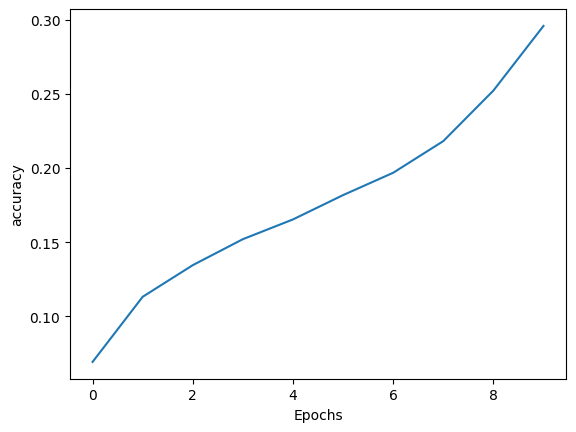

In [20]:
plot_graphs(history, 'accuracy')

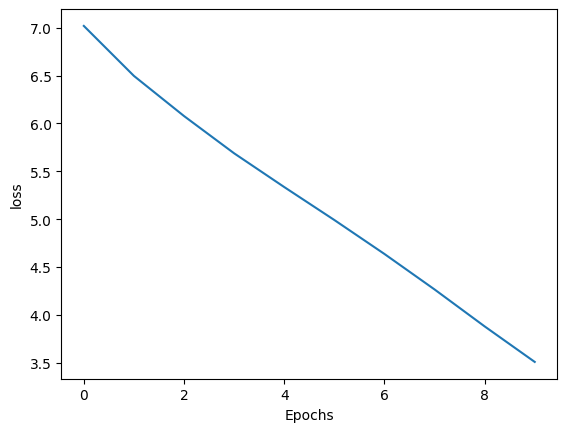

In [21]:
plot_graphs(history, 'loss')

<a name="new"></a>
## **Text Generation (Prediction)**

In [22]:
def generate_text(seed_text, next_words, model, max_sequence_len):

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        token_list = pad_sequences([token_list], maxlen = max_sequence_len - 1, padding='pre')

        predicted = model.predict(token_list, verbose=0)

        classes_x = np.argmax(predicted,axis=1)

        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == classes_x:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

- **seed_text**: the initial words that will be passed for text generation.
- **predict_classes**: it will return the token id for the predicted word.
- **predicted**: It's the token id for a predicted word and this will be converted back into a word using the - dictionary **tokenizer.word_index .items()**.
- **next_words**: It’s the number of next words we want to be predicted.

## **Generation of Text Using Initial Text or "seed_text" and Maximum Sequence Length"**

In [23]:
print (generate_text("implementation of ", 2, model, max_sequence_len))
print (generate_text("implementation of ", 4, model, max_sequence_len))

Implementation Of  The Recovering
Implementation Of  The Recovering Judgment Addict


In [24]:
print (generate_text("How to use", 5, model, max_sequence_len))

How To Use A Most Of Shitty Interviews


In [25]:
print (generate_text("Forecasting ", 7, model, max_sequence_len))

Forecasting  Up The Simple Cycle Of Living And


In [26]:
print (generate_text("Data", 3, model, max_sequence_len))

Data Science Productionization The


In [27]:
print (generate_text("Deep Learning is a ", 1, model, max_sequence_len))

Deep Learning Is A  Frontier


### **Observation**
As we can see, all text generated by our Model is basically replicating how humans would type out a Headline. That means, our model has learned how to generate text like the data it was trained on.

### **Saving the Model as a Pickle file**

In [28]:
model.save("text_generator.h5")